# 4D-STEM Density Map Analysis

This notebook performs radial density analysis on 4D-STEM data, computing density maps and visualizing diffraction patterns.

In [3]:
# Import required libraries
import py4DSTEM
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import os

# Configure matplotlib for better display
%matplotlib widget
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [6, 4]

## Data Loading and Preprocessing

Load and crop the 4D-STEM data. The cropping helps reduce file size and focuses on the relevant region.

**Data Requirements:**
- The raw data file `1120_file.h5` (1.4 GB) is required to run this notebook
- Download from Zenodo: 10.5281/zenodo.17673178
- Place the file in the same directory as this notebook
- Once processed, a smaller cropped file (`s_crop.h5`) will be saved for faster reloading

In [19]:
def load_and_crop_data(filename, crop_range=(0, 350), save_preprocessed=True):
    """Load and optionally crop large 4D-STEM file and save for reuse."""
    print(f"Loading data from: {filename}")
    s = py4DSTEM.io.read(filename)
    print(f"Original data shape: {s.data.shape}")
    
    # Extract calibration metadata
    pixel_size = None
    pixel_units = None
    
    # Try to get calibration from py4DSTEM DataCube
    if hasattr(s, 'calibration'):
        print(f"Calibration object found: {s.calibration}")
        if hasattr(s.calibration, 'get_R_pixel_size'):
            pixel_size = s.calibration.get_R_pixel_size()
            pixel_units = s.calibration.get_R_pixel_units()
            print(f"Pixel size: {pixel_size} {pixel_units}")
    
    # Crop the data array directly
    data_crop = s.data[:, crop_range[0]:crop_range[1], :, :]
    print(f"Cropped data shape: {data_crop.shape}")

    if save_preprocessed:
        # Save as numpy array along with metadata
        np.save("s_crop_data.npy", data_crop)
        # Save metadata separately
        metadata = {'pixel_size': pixel_size, 'pixel_units': pixel_units}
        np.save("s_crop_metadata.npy", metadata)
        print("Preprocessed data saved as s_crop_data.npy")
        print(f"Metadata saved: {metadata}")

    return data_crop, pixel_size, pixel_units

In [20]:
# Load data
# Large data file (SiO2_1120_file.h5, 1.4 GB) should be downloaded from Zenodo
# and placed in the same directory as this notebook.
# Zenodo DOI: 10.5281/zenodo.17673178 

preprocessed_file = "s_crop_data.npy"
metadata_file = "s_crop_metadata.npy"
# Try local directory first, then fall back to full path
original_file_local = "SiO2_1120_file.h5"
original_file_full = r"G:\Analytik\Personal\Vivek\PC_Titan_EMPA\PED\20250620_PED_SiO2_NI\SiO2_1120_file.h5"

# Determine which file to use
if os.path.exists(original_file_local):
    original_file = original_file_local
elif os.path.exists(original_file_full):
    original_file = original_file_full
else:
    original_file = original_file_local  # Default for error message

# Check if the original H5 file exists
if not os.path.exists(original_file) and not os.path.exists(preprocessed_file):
    print("=" * 70)
    print("DATA FILE NOT FOUND")
    print("=" * 70)
    print(f"Data file 'SiO2_1120_file.h5' not found.")
    print(f"Please download it from Zenodo:")
    print(f"DOI: 10.5281/zenodo.17673178")
    print(f"Place the file in the same directory as this notebook.")
    print(f"The file is 1.4 GB and is required to run this analysis.")
    print("=" * 70)
    # Uncomment the line below to raise an error instead of just printing a warning:
    # raise FileNotFoundError(f"Data file 'SiO2_1120_file.h5' not found.")

if os.path.exists(preprocessed_file):
    print("Loading preprocessed file...")
    data_crop = np.load(preprocessed_file)
    # Load metadata if available
    if os.path.exists(metadata_file):
        metadata = np.load(metadata_file, allow_pickle=True).item()
        pixel_size = metadata.get('pixel_size', 1.0)
        pixel_units = metadata.get('pixel_units', 'nm')
        print(f"Loaded metadata - Pixel size: {pixel_size} {pixel_units}")
    else:
        pixel_size = 1.0
        pixel_units = 'nm'
        print("No metadata file found, using default pixel size: 1.0 nm")
    print("Loaded preprocessed file.")
elif os.path.exists(original_file):
    print("Preprocessed file not found, loading and processing original file...")
    data_crop, pixel_size, pixel_units = load_and_crop_data(original_file, crop_range=(0, 350))
    if pixel_size is None:
        pixel_size = 1.0
        pixel_units = 'nm'
        print("Could not extract pixel size from file, using default: 1.0 nm")
else:
    print("\nSkipping data loading - files not found.")
    print("This cell will produce an error if you try to run subsequent cells.")
    pixel_size = 1.0
    pixel_units = 'nm'

if 'data_crop' in locals():
    print(f"Final data shape: {data_crop.shape}")
    print(f"Pixel scale: {pixel_size} {pixel_units}")
    print(f"Data ready for density map computation")

Preprocessed file not found, loading and processing original file...
Loading data from: G:\Analytik\Personal\Vivek\PC_Titan_EMPA\PED\20250620_PED_SiO2_NI\SiO2_1120_file.h5
Original data shape: (392, 179, 144, 144)
Cropped data shape: (392, 179, 144, 144)
Original data shape: (392, 179, 144, 144)
Cropped data shape: (392, 179, 144, 144)
Preprocessed data saved as s_crop_data.npy
Metadata saved: {'pixel_size': None, 'pixel_units': None}
Could not extract pixel size from file, using default: 1.0 nm
Final data shape: (392, 179, 144, 144)
Pixel scale: 1.0 nm
Data ready for density map computation
Preprocessed data saved as s_crop_data.npy
Metadata saved: {'pixel_size': None, 'pixel_units': None}
Could not extract pixel size from file, using default: 1.0 nm
Final data shape: (392, 179, 144, 144)
Pixel scale: 1.0 nm
Data ready for density map computation


## Density Map Computation

Compute the radial density map by calculating the first moment of the radial profile for each diffraction pattern.

In [21]:
def compute_density_map(data):
    """Compute radial density map."""
    print("Computing density map...")
    
    y, x = np.indices(data.shape[2:])
    center = np.array([(y.max() - y.min()) / 2.0, (x.max() - x.min()) / 2.0])
    r = np.sqrt((y - center[0])**2 + (x - center[1])**2).astype(int)

    density_map = np.zeros(data.shape[:2])
    total_pixels = data.shape[0] * data.shape[1]

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            dp = data[i, j]
            r_profile = np.bincount(r.ravel(), dp.ravel())
            r_norm = np.bincount(r.ravel())
            r_profile = r_profile / r_norm
            r_indices = np.arange(len(r_profile))
            first_moment = np.sum(r_profile * r_indices) / np.sum(r_profile)
            density_map[i, j] = first_moment
        
        # Progress indicator
        if (i + 1) % 30 == 0:
            progress = ((i + 1) * data.shape[1]) / total_pixels * 100
            print(f"Progress: {progress:.1f}%")

    print("Density map computation complete!")
    return density_map

In [22]:
# Compute density map
density_map = compute_density_map(data_crop)
print(f"Density map shape: {density_map.shape}")
print(f"Density range: {density_map.min():.2f} - {density_map.max():.2f}")

Computing density map...
Progress: 7.7%
Progress: 7.7%
Progress: 15.3%
Progress: 15.3%
Progress: 23.0%
Progress: 23.0%
Progress: 30.6%
Progress: 30.6%
Progress: 38.3%
Progress: 38.3%
Progress: 45.9%
Progress: 45.9%
Progress: 53.6%
Progress: 53.6%
Progress: 61.2%
Progress: 61.2%
Progress: 68.9%
Progress: 68.9%
Progress: 76.5%
Progress: 76.5%
Progress: 84.2%
Progress: 84.2%
Progress: 91.8%
Progress: 91.8%
Progress: 99.5%
Density map computation complete!
Density map shape: (392, 179)
Density range: 21.80 - 52.09
Progress: 99.5%
Density map computation complete!
Density map shape: (392, 179)
Density range: 21.80 - 52.09


## Visualization Functions

In [23]:
def plot_density_map(density_map, pixel_scale_nm=1.0, scalebar_length_nm=60, filename='SiO2_density_map_20251002_1704.png'):
    """Plot density map with scalebar and color map."""
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue → White → Red
    cm = LinearSegmentedColormap.from_list('density_cmap', colors, N=256)

    vmin = np.percentile(density_map, 3)
    vmax = np.percentile(density_map, 98)
    plt.imshow(density_map, cmap=cm, vmin=vmin, vmax=vmax)

    cbar = plt.colorbar(label='Relative Density (a.u.)')
    cbar.set_ticks([])
    # Add scale bar
    ax = plt.gca()
    scalebar_length_pixels = scalebar_length_nm / pixel_scale_nm

    # Convert scalebar length from pixels to axes fraction
    img_shape = density_map.shape[1]  # width in pixels
    scalebar_length_frac = scalebar_length_pixels / img_shape
    scalebar_height = 0.02  # fraction of axes height

    # Set the center x position for the scalebar and text
    center_x = 0.2  # middle of the axes
    text_y = 0.08   # y position for the text (slightly above the bar)
    bar_y = 0.05    # y position for the bar (bottom of the text)

    # Calculate left edge of the rectangle so it's centered under the text
    rect_x = center_x - scalebar_length_frac / 2

    # Add rectangle as scale bar
    rect = Rectangle(
        (rect_x, bar_y),  # X, Y position in axes fraction (0 to 1)
        scalebar_length_frac,
        scalebar_height,
        linewidth=1,
        edgecolor='black',
        facecolor='white',
        transform=ax.transAxes
    )
    ax.add_patch(rect)

    # Add text centered above the scale bar
    ax.text(
        center_x, text_y,  # X, Y position in axes fraction (0 to 1)
        f'{scalebar_length_nm} nm',
        ha='center',
        va='bottom',
        color='white',
        fontsize='small',
        fontweight='bold',
        transform=ax.transAxes
    )
    plt.xticks([])
    plt.yticks([])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


In [24]:

def plot_diffraction_example(data, kind='average', region=(10, 20, 10, 20)):
    """Plot either a single or average diffraction pattern without colorbar and title."""
    if kind == 'single':
        i = (region[0] + region[1]) // 2
        j = (region[2] + region[3]) // 2
        dp = data[i, j]
    elif kind == 'average':
        dp = data[region[0]:region[1], region[2]:region[3]].mean(axis=(0, 1))
    else:
        raise ValueError("kind must be 'single' or 'average'")

    plt.figure(figsize=(6, 6))
    plt.imshow(dp, cmap='gray')
    plt.axis('off')
    plt.savefig(f'diffraction_pattern_{kind}_{region}.jpg', dpi=300, bbox_inches='tight')
    plt.show()

In [29]:
def show_region_on_density_map(density_map, region, title='Selected Region'):
    """Visualize which region is selected on the density map."""
    plt.figure(figsize=(8, 6))
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue → White → Red
    cm = LinearSegmentedColormap.from_list('density_cmap', colors, N=256)
    
    vmin = np.percentile(density_map, 3)
    vmax = np.percentile(density_map, 98)
    plt.imshow(density_map, cmap=cm, vmin=vmin, vmax=vmax)
    
    # Draw rectangle showing the selected region
    # region format: (y_start, y_end, x_start, x_end)
    rect = Rectangle((region[2], region[0]), 
                     region[3] - region[2], 
                     region[1] - region[0],
                     linewidth=2, edgecolor='yellow', facecolor='none')
    plt.gca().add_patch(rect)
    
    plt.title(title)
    plt.colorbar(label='Relative Density (a.u.)')
    plt.xlabel('X position (pixels)')
    plt.ylabel('Y position (pixels)')
    plt.show()
    
    print(f"Region: Y=[{region[0]}:{region[1]}], X=[{region[2]}:{region[3]}]")
    print(f"Average density in region: {density_map[region[0]:region[1], region[2]:region[3]].mean():.2f}")

## Interactive Analysis

Now let's visualize the results. You can modify the parameters in the cells below to explore different aspects of your data.

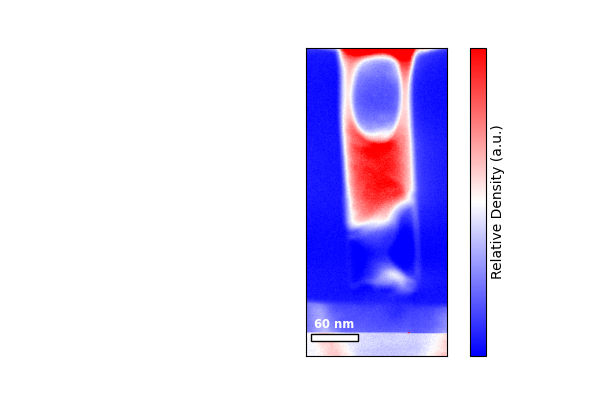

In [25]:
# Plot the density map
# Uses pixel_size extracted from the data file metadata
plot_density_map(density_map, pixel_scale_nm=pixel_size, scalebar_length_nm=60)

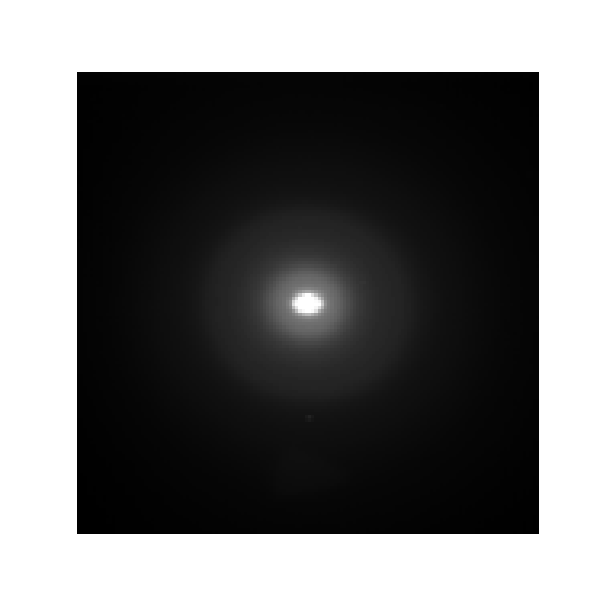

In [30]:
# Plot average diffraction pattern
plot_diffraction_example(data_crop, kind='average', region=(10, 50, 140, 180))

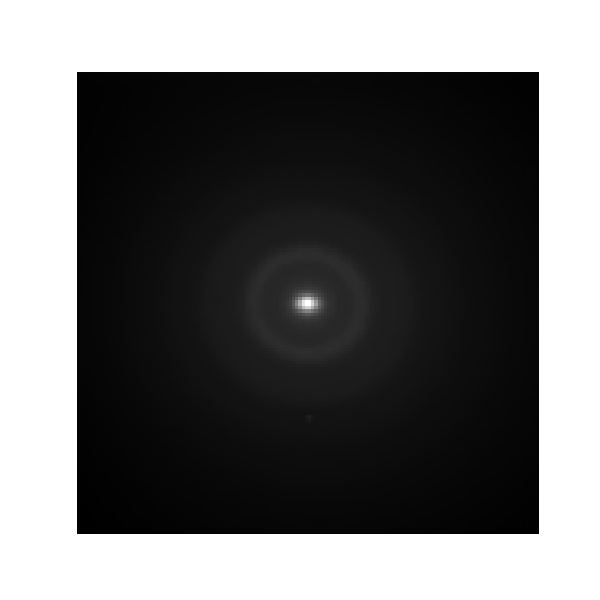

In [34]:
# Plot single diffraction pattern
plot_diffraction_example(data_crop, kind='average', region=(140, 180, 80, 120))

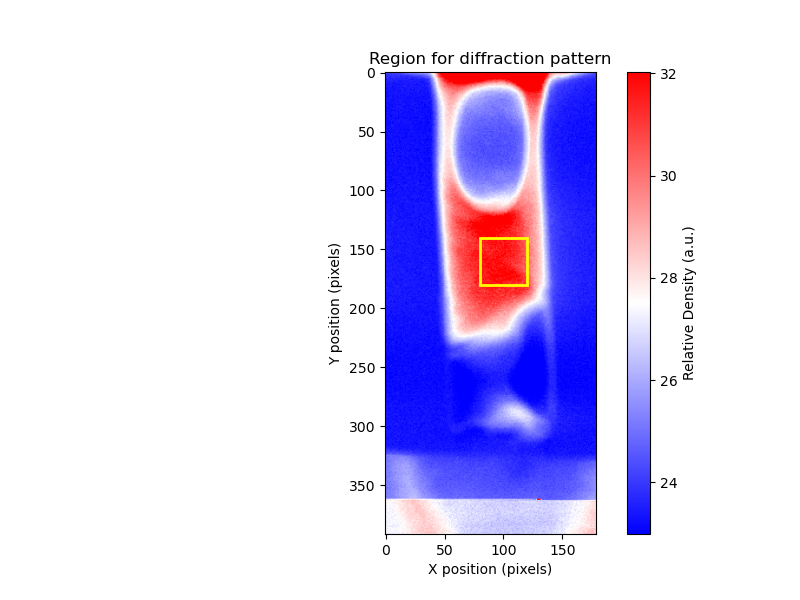

Region: Y=[140:180], X=[80:120]
Average density in region: 31.48


In [35]:
# Visualize which region you're selecting
show_region_on_density_map(density_map, region=(140, 180, 80, 120), 
                           title='Region for diffraction pattern')

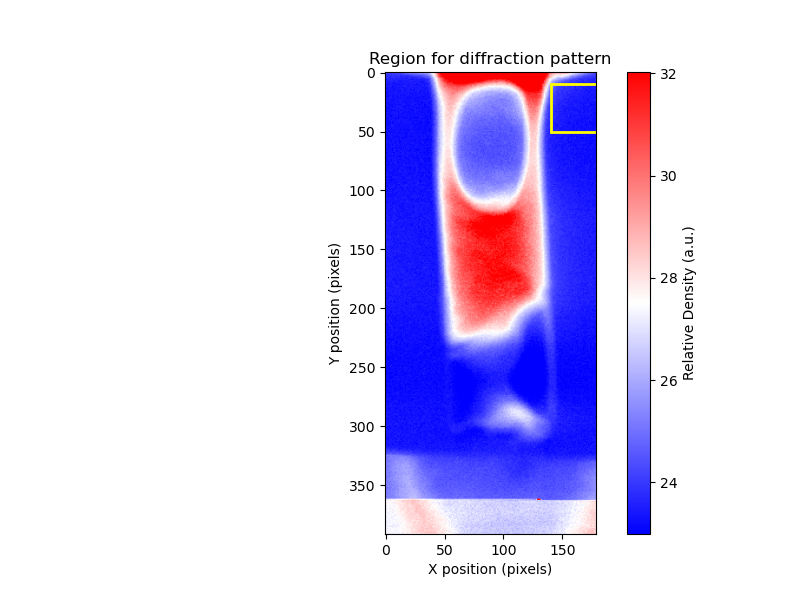

Region: Y=[10:50], X=[140:180]
Average density in region: 23.55


In [36]:
# Visualize which region you're selecting
show_region_on_density_map(density_map, region=(10, 50, 140, 180), 
                           title='Region for diffraction pattern')